Explanation of notebooks: 

- The $\textbf{Exoplanet Practice notebook}$ models the transits for the planetary system, and subtracts the model from the pld data to see if histogram of noise is gaussian. This notebook finds there is lots of non-gaussian noise, indiciating a bug. 
- The $\textbf{Outliers Removal - Histogram-bug notebook}$ tries using MAST lightkurve instead of pld but still replicates this bug.
- The $\textbf{TPF files notebook}$ explains why the pld data had weird features. If I stitch lightcurves from different quarters and then flatten them, they introduce those features. If I flatten each quarter and THEN stitch, the features are no longer there. 
- The $\textbf{Outliers Removal - Histogram-pld notebook}$ goes back to using pld but fixes the bug (found to be using the wrong time array in exoplanet model). This notebook also tries to explore the pld data's weird featurues  
- The $\textbf{Outliers Removal - Histogram-sap notebook}$ tries using sap but fixes the time array bug 
- The $\textbf{Outliers Removal - Histogram notebook}$ uses MAST lightkurve and fixes the bug (found to be using the wrong time array in exoplanet model). Histogram looks good but folded light curve found to have shoulders. 

The MAST lightkurve + time array bug fix was the combination that led to the least amount of outliers. However, the folded light curve had shoulders, so flattening needs to be removed. 


In [1]:
import exoplanet as xo 
import lightkurve as lk 
import astropy.units as units
import matplotlib.pyplot as plt 
import numpy as np 
%matplotlib inline
from astropy.time import Time 
import sys 
sys.path.append("helpers")
import data 
import xo_archive
xo.utils.docs_setup()
import matplotlib
matplotlib.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.family'] = 'DeJavu Serif'
import matplotlib.font_manager
from scipy.stats import norm 
import statistics
from importlib import reload

reload(data)

<module 'data' from '/Users/suissa/radius-valley/helpers/data.py'>

In [2]:
planet_parameters = xo_archive.get_exoplanet_parameters("Kepler-109 ", which="composite")

param_lists = xo_archive.transpose_parameters(planet_parameters)
param_lists['pl_tranmid_bkjd'] = [i - 2454833 for i in param_lists['pl_tranmid']]

students-t distribution incompatible with Gaussian Processes 
correlated noise - multidimensional GP 

1) outliers could be due to flares, poor fit to the data, systematics 
2) systematic noise - pointing drift 
3) stellar correlations 

Ideally need a probability distribution to account for all of these 

1 and 3 are basically impossible to implement simultaneously 
1 use histogram or CDF 
2 look at correlation between x/y position vs the flux 

need to look if theres any correlation in x and y positions 

PLD - look at it in the lightkurve package, should have removed large dips 

ACF for 3 - auto correlation function 

(0.995, 1.01)

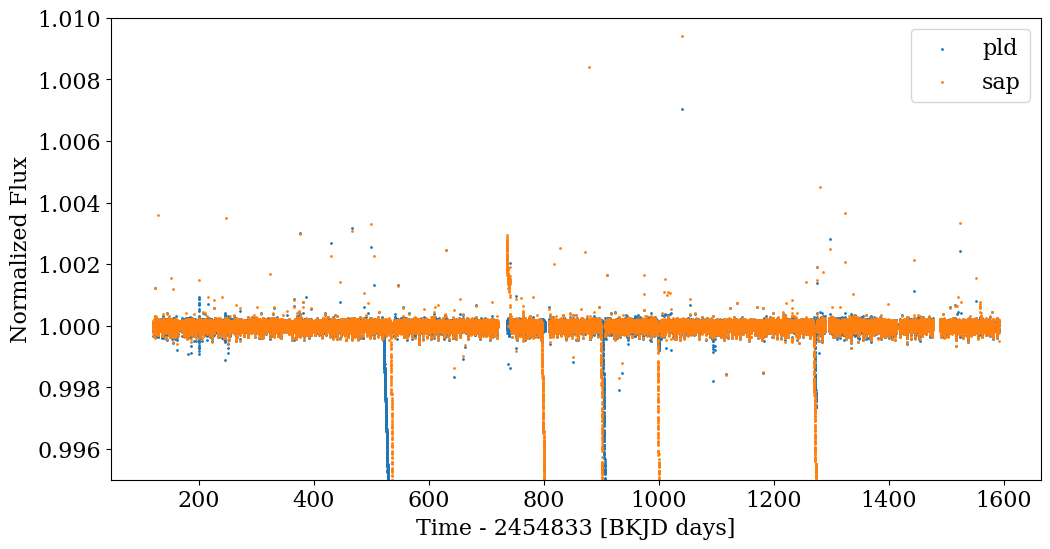

In [3]:
lc_sap = data.get_flattened_lc("Kepler-109", mission="Kepler", exptime=1800, method='sap')
lc_pld = data.get_flattened_lc("Kepler-109", mission="Kepler", exptime=1800, method='pld')
#lc_pipe = data.get_flattened_lc("Kepler-109", mission="Kepler", exptime=1800, method='pipeline')
#lc_cbv = data.get_flattened_lc("Kepler-109", mission="Kepler", exptime=1800, method='cbv')
fig, ax = plt.subplots(figsize=(12,6))
lc_pld.scatter(ax=ax,norm=True,label='pld')
lc_sap.scatter(ax=ax,norm=True,label='sap')
#lc_pipe.scatter(ax=ax,norm=True,label='pipeline')
#lc_cbv.scatter(ax=ax,norm=True,label='cbv')
plt.legend()
plt.ylim(0.995, 1.01)

(200.0, 600.0)

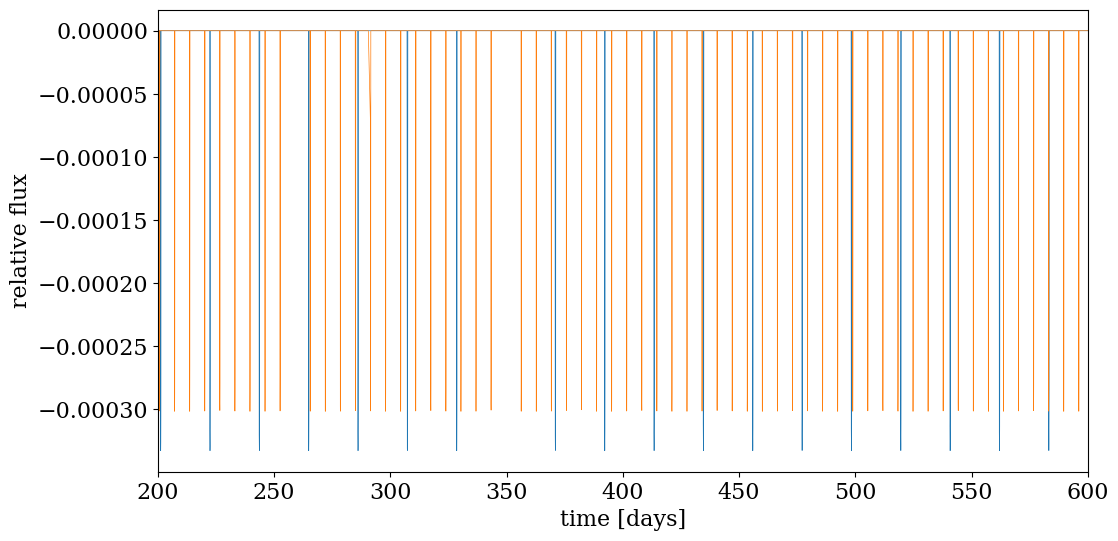

In [4]:
constant = 1

orbits = {}
for i in range(len(param_lists['pl_letter'])):
    orbits[param_lists['pl_letter'][i]] = xo.orbits.SimpleTransitOrbit(period=param_lists["pl_orbper"][i], t0=(param_lists['pl_tranmid_bkjd'][i]),
                                                                   b=param_lists['pl_imppar'][i], duration=param_lists['pl_trandur'][i]/24,
                                                                   r_star=param_lists['st_rad'][i],ror=param_lists['pl_ratror'][i])
t = lc_pld.time.value
u = [0.2, 0.2]

light_curves = {}
for i in range(len(param_lists['pl_letter'])):
    light_curves[param_lists['pl_letter'][i]] = (xo.LimbDarkLightCurve(*u).get_light_curve(orbit=orbits[param_lists['pl_letter'][i]], r=param_lists['st_rad'][i]*param_lists['pl_ratror'][i],t=t)
    .eval())

plt.figure(figsize=(12,6))
plt.plot(t, light_curves['c'], color="C0", lw=0.5)
plt.plot(t, light_curves['b'], color="C1", lw=0.5)
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.xlim(200,600)

In [5]:
dataset = np.array(lc_pld.flux)

model = light_curves['c']+light_curves['b']

In [6]:
model = model.flatten()

In [7]:
difference = (dataset - model)

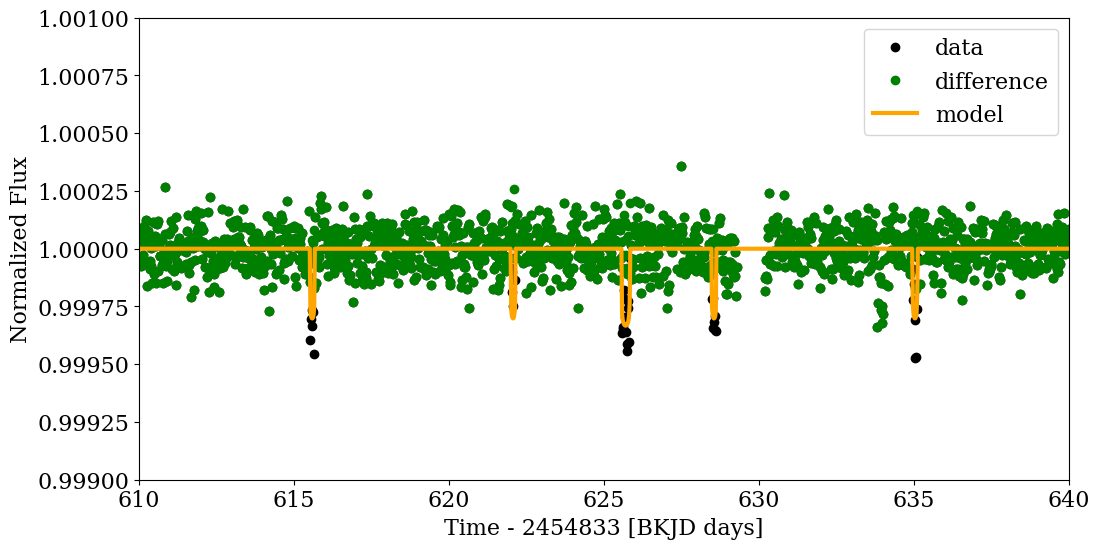

In [8]:
p = lc_pld.scatter()
plt.close()

fig, ax = plt.subplots(figsize=(12,6))
plt.plot(lc_pld.time.value,lc_pld.flux.value,color='k',marker='o',ls='',label='data')
plt.plot(lc_pld.time.value,difference,marker='o',ls='',color='green',label='difference')
plt.plot(t, model+1,color='orange',lw=3,label='model')
plt.xlabel(p.get_xlabel())
plt.ylabel(p.get_ylabel())
plt.xlim(610,640)
plt.ylim(0.999, 1.001)
plt.legend()

(0.9994, 1.0006)

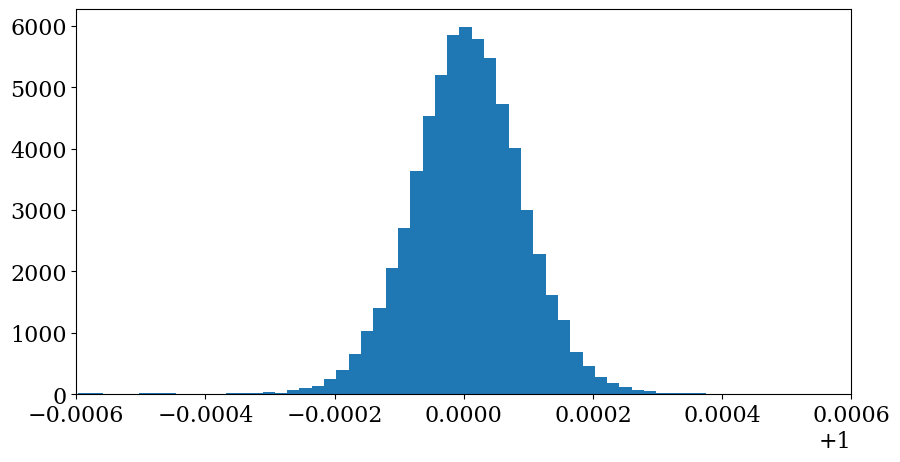

In [9]:
plt.figure(figsize=(10,5))
plt.hist(difference, bins=1000)
plt.xlim(0.9994, 1.0006)

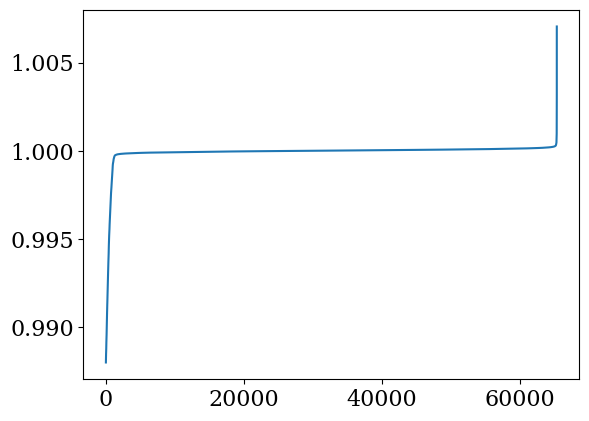

In [10]:
diff_sorted = np.sort(difference)
N = len(diff_sorted)
p = np.arange(N)
plt.plot(p, diff_sorted)

In [11]:
# find the two points to get std 

f = lambda x: np.interp(x, p, diff_sorted)

one_sigma_pos = f((0.8413)*N)
one_sigma_neg = f((1-0.8413)*N)
print(one_sigma_neg, one_sigma_pos)

std_calculated = (one_sigma_pos - one_sigma_neg)/2
print(std_calculated)


0.9999186821751792 1.0000872283595148
8.427309216779699e-05


(0.999, 1.001)

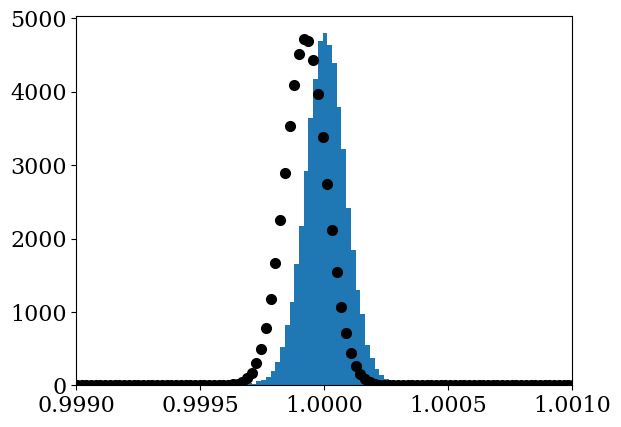

In [12]:
mu, std = norm.fit(difference)  
h, bins = np.histogram(difference, bins=1000)
plt.hist(difference, bins=bins, density=True)
plt.scatter(bins, norm(mu, std_calculated).pdf(bins), linewidth=2, color='black')
#plt.axvline(mu-(2*std_calculated),color='k')
#plt.axvline(mu+(2*std_calculated),color='k')
plt.xlim(0.999,1.001)

In [13]:
# note how we use the median as the center point to cut around 
mean_tweaked = np.mean(difference[((np.median(difference) - std_calculated) < difference) & (difference < (np.median(difference) + std_calculated))])
print(mean_tweaked)

1.0000047448692952


(0.999, 1.001)

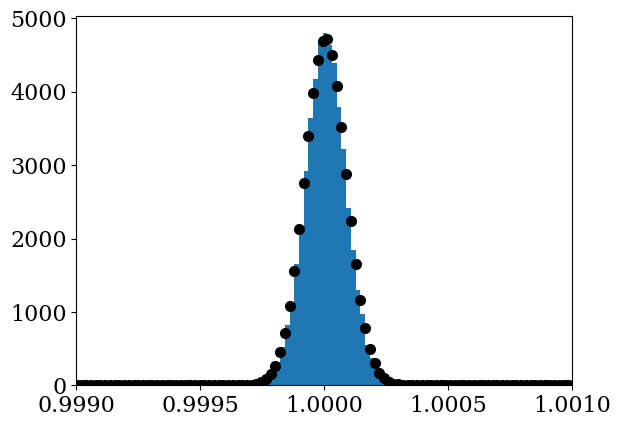

In [14]:
mu, std = norm.fit(difference)  
h, bins = np.histogram(difference, bins=1000)
plt.hist(difference, bins=bins, density=True)
plt.scatter(bins, norm(mean_tweaked, std_calculated).pdf(bins), linewidth=2, color='black')
#plt.axvline(mu-(2*std_calculated),color='k')
#plt.axvline(mu+(2*std_calculated),color='k')
plt.xlim(0.999,1.001)

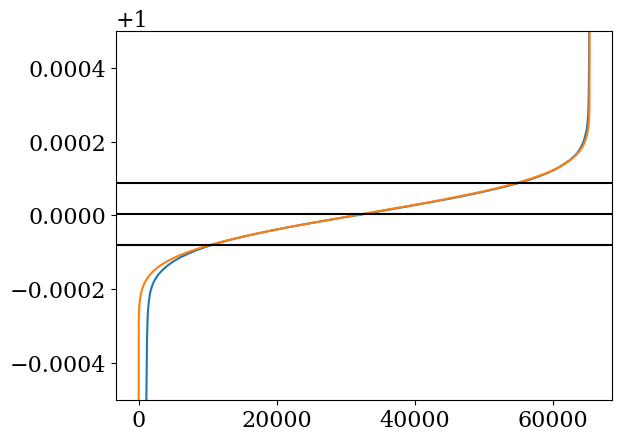

In [15]:
norm_cdf = norm.cdf((diff_sorted - mean_tweaked)/std_calculated)

diff_sorted = np.sort(difference)
N = len(diff_sorted)
p = np.arange(N)
plt.plot(p, diff_sorted)
plt.plot(norm_cdf*N, diff_sorted)
plt.ylim(0.9995,1.0005)
plt.axhline(mean_tweaked,color='k')
plt.axhline(mean_tweaked-std_calculated,color='k')
plt.axhline(mean_tweaked+std_calculated,color='k')

In [16]:
good_flux = lc_pld.flux[(difference > (mean_tweaked-std_calculated)) & (difference < (mean_tweaked+std_calculated))]
good_time = lc_pld.time[(difference > (mean_tweaked-std_calculated)) & (difference < (mean_tweaked+std_calculated))]

In [17]:
# find separation of curves 

(0.999, 1.001)

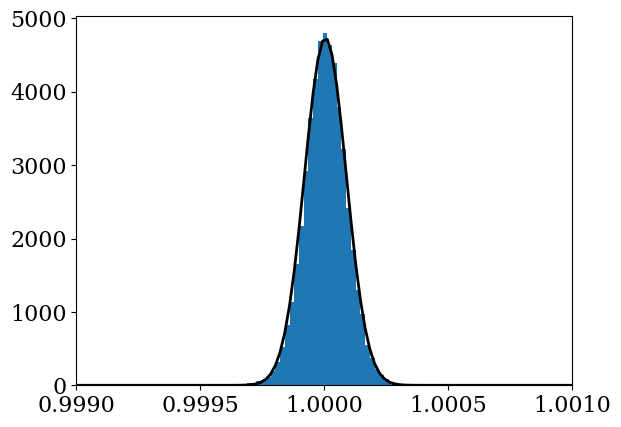

In [18]:
h, bins = np.histogram(difference, bins=1000)
plt.hist(difference, bins=bins, density=True)
plt.plot(bins, norm(mean_tweaked, std_calculated).pdf(bins), linewidth=2, color='black')
#plt.axvline(mean_tweaked-(std_calculated),color='k')
#plt.axvline(mean_tweaked+(std_calculated),color='k')
#plt.axvline(mean_tweaked-(2*std_calculated),color='k')
#plt.axvline(mean_tweaked+(2*std_calculated),color='k')
#plt.ylim(1e-6,5000)
plt.xlim(0.999,1.001)
#plt.yscale('log')

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Liberation Sans
findfont: Font family ['sans'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans' not found because none of the following families were found: Liberation Sans
findfont: Font family ['sans'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans' not found because none of the following families were found: Liberation Sans
findfont: Font family ['sans'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans' not found because none of the following families were found: Liberation Sans


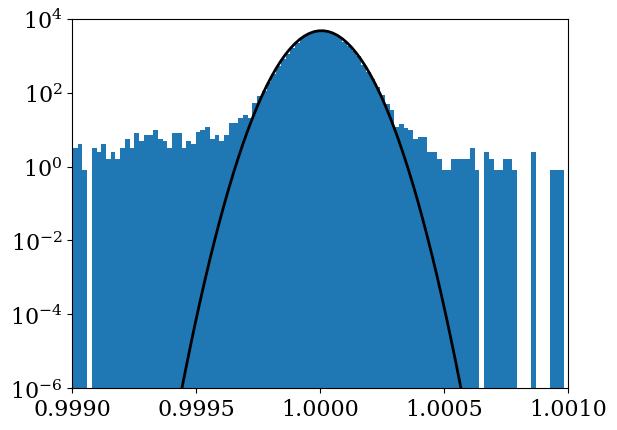

In [19]:
h, bins = np.histogram(difference, bins=1000)
plt.hist(difference, bins=bins, density=True)
plt.plot(bins, norm(mean_tweaked, std_calculated).pdf(bins), linewidth=2, color='black')
#plt.axvline(mean_tweaked-(std_calculated),color='k')
#plt.axvline(mean_tweaked+(std_calculated),color='k')
#plt.axvline(mean_tweaked-(2*std_calculated),color='k')
#plt.axvline(mean_tweaked+(2*std_calculated),color='k')
plt.ylim(1e-6,1e4)
plt.xlim(0.999,1.001)
plt.yscale('log')

## Investigating quality masks for light curves

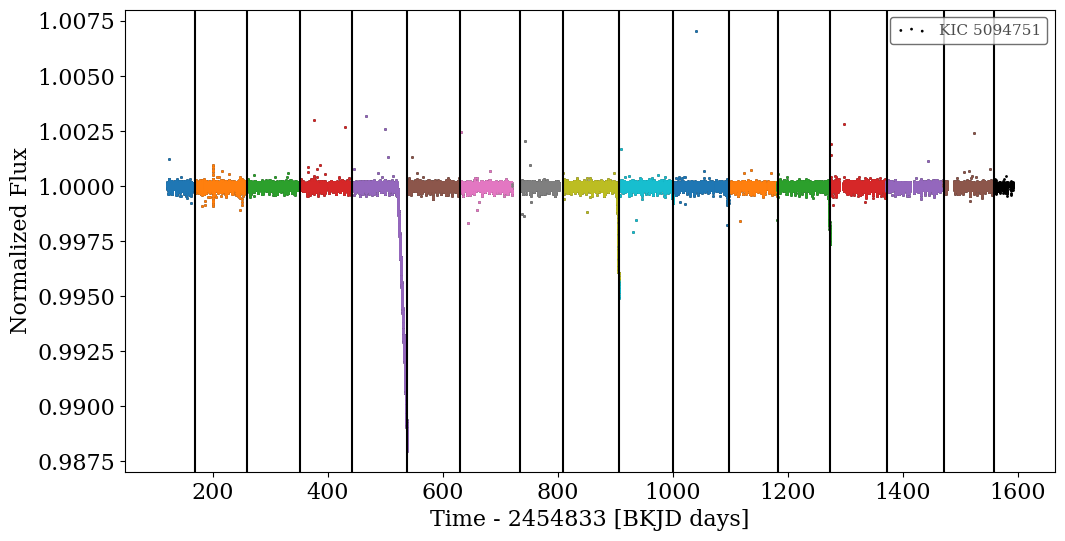

In [20]:
fig, ax = plt.subplots(figsize=(12,6))
lc_pld.scatter(ax=ax,color='k')
#plt.xlim(255,265)

lc_pld[(120 < lc_pld['time'].value) & (lc_pld['time'].value < 167.5)].scatter(ax=ax,label=None)
lc_pld[(167.5 < lc_pld['time'].value) & (lc_pld['time'].value < 258.5)].scatter(ax=ax,label=None)
lc_pld[(258.5 < lc_pld['time'].value) & (lc_pld['time'].value < 349.5)].scatter(ax=ax,label=None)
lc_pld[(349.5 < lc_pld['time'].value) & (lc_pld['time'].value < 441.5)].scatter(ax=ax,label=None)
lc_pld[(441.5 < lc_pld['time'].value) & (lc_pld['time'].value < 538.5)].scatter(ax=ax,label=None)
lc_pld[(538.5 < lc_pld['time'].value) & (lc_pld['time'].value < 629.5)].scatter(ax=ax,label=None)
lc_pld[(629.5 < lc_pld['time'].value) & (lc_pld['time'].value < 719.5)].scatter(ax=ax,label=None)
lc_pld[(719.5 < lc_pld['time'].value) & (lc_pld['time'].value < 806.5)].scatter(ax=ax,label=None)
lc_pld[(806.5 < lc_pld['time'].value) & (lc_pld['time'].value < 905.5)].scatter(ax=ax,label=None)
lc_pld[(905.5 < lc_pld['time'].value) & (lc_pld['time'].value < 1000.5)].scatter(ax=ax,label=None)
lc_pld[(1000.5 < lc_pld['time'].value) & (lc_pld['time'].value < 1097.5)].scatter(ax=ax,label=None)
lc_pld[(1097.5 < lc_pld['time'].value) & (lc_pld['time'].value < 1181.5)].scatter(ax=ax,label=None)
lc_pld[(1181.5 < lc_pld['time'].value) & (lc_pld['time'].value < 1273.5)].scatter(ax=ax,label=None)
lc_pld[(1273.5 < lc_pld['time'].value) & (lc_pld['time'].value < 1370.5)].scatter(ax=ax,label=None)
lc_pld[(1370.5 < lc_pld['time'].value) & (lc_pld['time'].value < 1470.5)].scatter(ax=ax,label=None)
lc_pld[(1470.5 < lc_pld['time'].value) & (lc_pld['time'].value < 1557.5)].scatter(ax=ax,label=None)
quarterlines = [169, 259, 351, 442, 538, 629, 734, 808, 906, 1000, 1098, 1182, 1273, 1372, 1471, 1558]
for i, q in enumerate(quarterlines):
    ax.axvline(q, c='k')


In [21]:
lc_cut = lc_pld[(120 < lc_pld['time'].value) & (lc_pld['time'].value < 1600)]

In [22]:
lc_cut

time,flux,flux_err,centroid_col,centroid_row,cadenceno,quality
,,,pix,pix,,
Time,float64,float64,float64,float64,int32,int32
120.53925136771431,0.9999828648508039,6.536116746598699e-05,764.3276170257348,569.5411822286007,568,0
120.55968591685087,1.0001686725152843,6.536530868700823e-05,764.3279873157151,569.540711284209,569,0
120.58012036610307,0.9999793746216069,6.536152494070653e-05,764.3285245781709,569.5413176437598,570,8192
120.6005550151167,1.0000218094336222,6.536348884802306e-05,764.3293930306683,569.5410468720531,571,0
120.62098956425325,1.0000306128034635,6.536310048158393e-05,764.3300197914905,569.5414939333165,572,0
120.64142401327263,1.0000510247471088,6.536329506855563e-05,764.3305300617495,569.5417866521659,573,0
...,...,...,...,...,...,...
1590.899356525253,1.00007596842905,6.677369018843823e-05,764.289639088929,569.5460903461521,72526,0


In [23]:
lk.KeplerQualityFlags.decode(8)

['Earth point']

In [89]:
codes = np.unique(lc_cut['quality']).value
print(codes)
print([lk.KeplerQualityFlags.decode(i) for i in codes])

[     0     16     64     80    128    144    192   2048   2064   2176
   2192   4096   4160   4176   8192   8208   8320   8336   8384  10368
  12288  12352 262144 393216 393232 393344 401408 401536]
[[], ['Zero crossing'], ['Argabrightening'], ['Zero crossing', 'Argabrightening'], ['Cosmic ray in optimal aperture'], ['Zero crossing', 'Cosmic ray in optimal aperture'], ['Argabrightening', 'Cosmic ray in optimal aperture'], ['Impulsive outlier'], ['Zero crossing', 'Impulsive outlier'], ['Cosmic ray in optimal aperture', 'Impulsive outlier'], ['Zero crossing', 'Cosmic ray in optimal aperture', 'Impulsive outlier'], ['Argabrightening on CCD'], ['Argabrightening', 'Argabrightening on CCD'], ['Zero crossing', 'Argabrightening', 'Argabrightening on CCD'], ['Cosmic ray in collateral data'], ['Zero crossing', 'Cosmic ray in collateral data'], ['Cosmic ray in optimal aperture', 'Cosmic ray in collateral data'], ['Zero crossing', 'Cosmic ray in optimal aperture', 'Cosmic ray in collateral data']

In [25]:
lc_16 = lc_cut[lc_cut['quality']==16]
lc_64 = lc_cut[lc_cut['quality']==64]
lc_128 = lc_cut[lc_cut['quality']==128]
lc_8192 = lc_cut[lc_cut['quality']==8192]
lc_393216 = lc_cut[lc_cut['quality']==393216]
lc_2176 = lc_cut[lc_cut['quality']==2176]
lc_144 = lc_cut[lc_cut['quality']==144]

(500.0, 550.0)

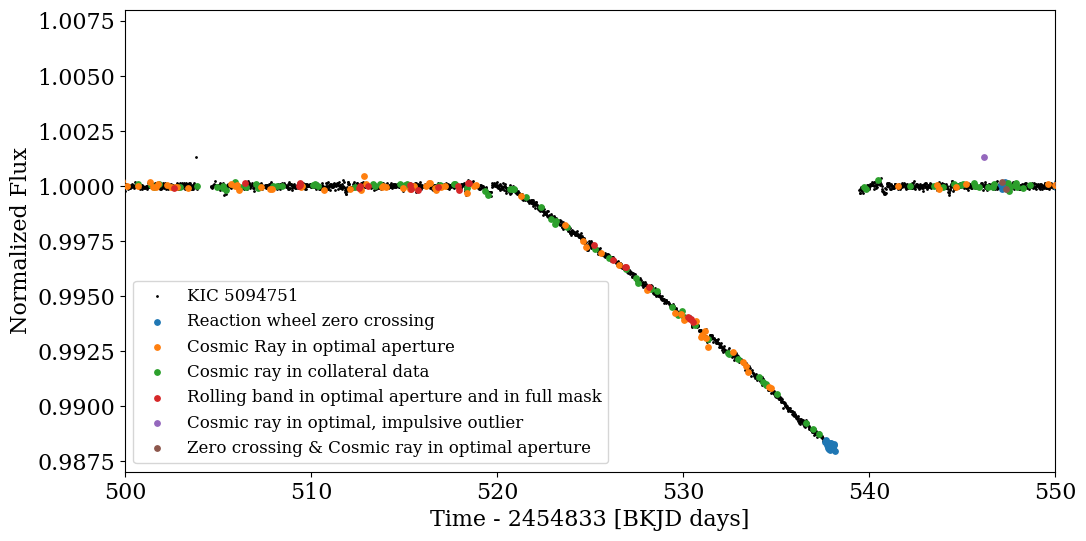

In [26]:
fig, ax = plt.subplots(figsize=(12,6))
lc_cut.scatter(ax=ax,color='k')
lc_16.scatter(ax=ax,marker='o',s=15,label='Reaction wheel zero crossing',zorder=1)
lc_128.scatter(ax=ax,marker='o',s=15,label='Cosmic Ray in optimal aperture',zorder=3)
lc_8192.scatter(ax=ax,marker='o',s=15,label='Cosmic ray in collateral data',zorder=2)
lc_393216.scatter(ax=ax,marker='o',s=15,label='Rolling band in optimal aperture and in full mask',zorder=4)
lc_2176.scatter(ax=ax,marker='o',s=15,label='Cosmic ray in optimal, impulsive outlier',zorder=5)
lc_144.scatter(ax=ax,marker='o',s=15,label='Zero crossing & Cosmic ray in optimal aperture',zorder=6)
plt.legend(fontsize=12)
plt.xlim(500,550)

In [28]:
lc_prf= data.get_flattened_lc("Kepler-109", mission="Kepler", exptime=1800, method='prf')


Process SpawnPoolWorker-104:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/radius-valley/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/anaconda3/envs/radius-valley/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/anaconda3/envs/radius-valley/lib/python3.10/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/opt/anaconda3/envs/radius-valley/lib/python3.10/multiprocessing/queues.py", line 367, in get
    return _ForkingPickler.loads(res)
_pickle.UnpicklingError: could not find MARK
Fitting cadences:  56%|████████████▉          | 265/473 [00:12<00:04, 42.35it/s]Process SpawnPoolWorker-105:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/radius-valley/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/anaconda3/envs/radius-valley/lib/python3.10/multiprocessing/process.py", li

In [ ]:
lc_cbv = data.get_flattened_lc("Kepler-109", mission="Kepler", exptime=1800, method='cbv')


(0.994, 1.01)

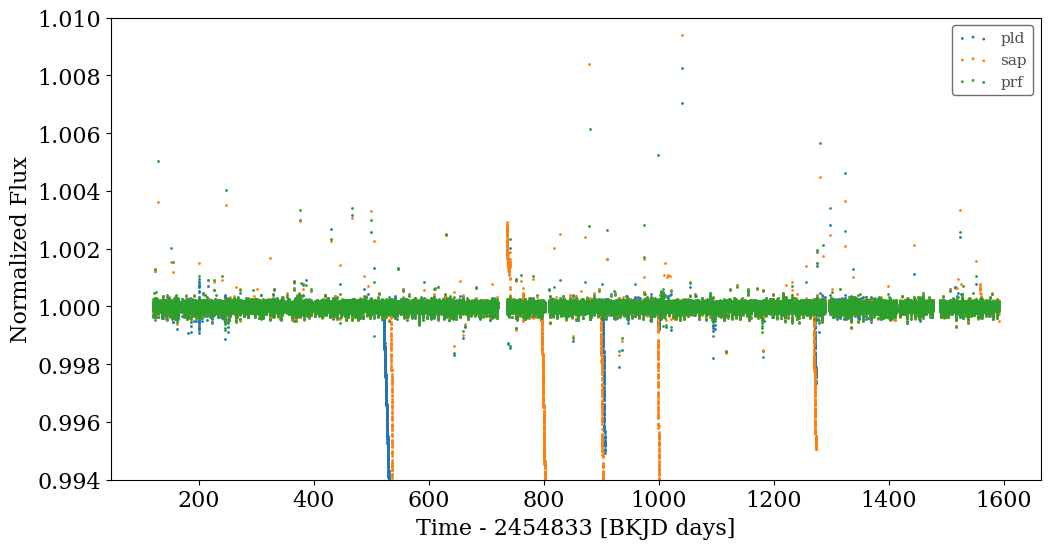

In [29]:
lc_sap = data.get_flattened_lc("Kepler-109", mission="Kepler", exptime=1800, method='sap')

fig, ax = plt.subplots(figsize=(12,6))
lc_pld.scatter(ax=ax, label='pld')
lc_sap.scatter(ax=ax, label='sap')
#lc_cbv.scatter(ax=ax, label='cbv')
lc_prf.scatter(ax=ax, label='prf')
plt.ylim(0.994,1.01)

Need to keep track of how many quarters observed and if pdcsap flux is available